In [1]:
# https://yt-project.org/
# Import the shiiiii

import yt
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from FLASH_functions import *
sys.path.append('../analysis_scripts')
from real_units_to_sim import get_osiris_units

# Assuming the correct numerical values are input into the file real_units_to sim, this should spit out the correct simulation values 
osiris = get_osiris_units()

---------- n_e = 7.8e+18 cm^-3 ----------
angular electron plasma frequency is: 1.58e+14 rad/s
--------------------------------------------------
times are normalized to inverse plasma frequency, one unit of simulation time corresponds to 6.35e-06 ns
space is normalized to electron inertial length, one unit of simulation length corresponds to 1.90e-04 cm
--------------------------------------------------
110000 G in simulation units would be 0.012

electron gyrotime would be 0.0005 ns
this corresponds to 81.438 simulation times

ion gyrotime (with ion mass of 100) would be 0.0517 ns
this corresponds to 8143.756 simulation times
--------------------------------------------------
alfven speed is 3.68e+07 cm/s
in simulation units this would be 0.001228

In order to simulate 5 ion gyrotimes by the time the shock has reached halfway across the box
we should set tmax = 40718
and the maximum bound of the box should be approx 3130
--------------------------------------------------
Te of 1118.0

## First, let's just take a look at some slices of the data

In [2]:
# plot_path = "./OSIRIS_transfer/MAGOFF/MagShockZ_hdf5_plt_cnt_0004"
plot_path = "./OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

ds = yt.load(plot_path)
list(ds.fields.flash)

yt : [INFO     ] 2024-08-23 15:59:44,452 Particle file found: MagShockZ_hdf5_chk_0005
yt : [INFO     ] 2024-08-23 15:59:44,486 Parameters: current_time              = 1.8520020414484505e-09
yt : [INFO     ] 2024-08-23 15:59:44,486 Parameters: domain_dimensions         = [288 272 288]
yt : [INFO     ] 2024-08-23 15:59:44,487 Parameters: domain_left_edge          = [-0.6   -0.075 -0.6  ]
yt : [INFO     ] 2024-08-23 15:59:44,487 Parameters: domain_right_edge         = [0.6 1.  0.6]
yt : [INFO     ] 2024-08-23 15:59:44,488 Parameters: cosmological_simulation   = 0


[On-Disk Field ('flash', 'absr'): (units: '', display_name: 'Absorption Coefficient'),
 On-Disk Field ('flash', 'cham'): (units: '', display_name: 'Chamber Material Fraction'),
 On-Disk Field ('flash', 'cond'): (units: '', display_name: 'Conductivity'),
 On-Disk Field ('flash', 'dbgs'): (units: '', display_name: 'Debug for Shocks'),
 On-Disk Field ('flash', 'dens'): (units: 'code_mass/code_length**3'),
 On-Disk Field ('flash', 'depo'): (units: 'code_length**2/code_time**2'),
 On-Disk Field ('flash', 'dfcf'): (units: '', display_name: 'Diffusion Equation Scalar'),
 On-Disk Field ('flash', 'divb'): (units: 'code_magnetic/code_length'),
 On-Disk Field ('flash', 'eele'): (units: 'code_mass * (code_length/code_time)**2', display_name: 'Electron Internal Specific Energy'),
 On-Disk Field ('flash', 'eint'): (units: 'code_length**2/code_time**2'),
 On-Disk Field ('flash', 'eion'): (units: 'code_mass * (code_length/code_time)**2', display_name: 'Ion Internal Specific Energy'),
 On-Disk Field ('

In [3]:
# relevant vars

print(ds.units)
print(ds.length_unit)
print(ds.mass_unit)
print(ds.domain_dimensions)
print(ds.refine_by)

1.0 cm
1.0 g
[288 272 288]
2


yt : [INFO     ] 2024-08-23 15:59:45,798 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:45,799 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:45,801 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:45,801 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:45,804 Making a fixed resolution buffer of (('flash', 'dens')) 800 by 800


dens at [0.  0.4 0. ] code_length: [2.48007124e-05] code_mass/code_length**3



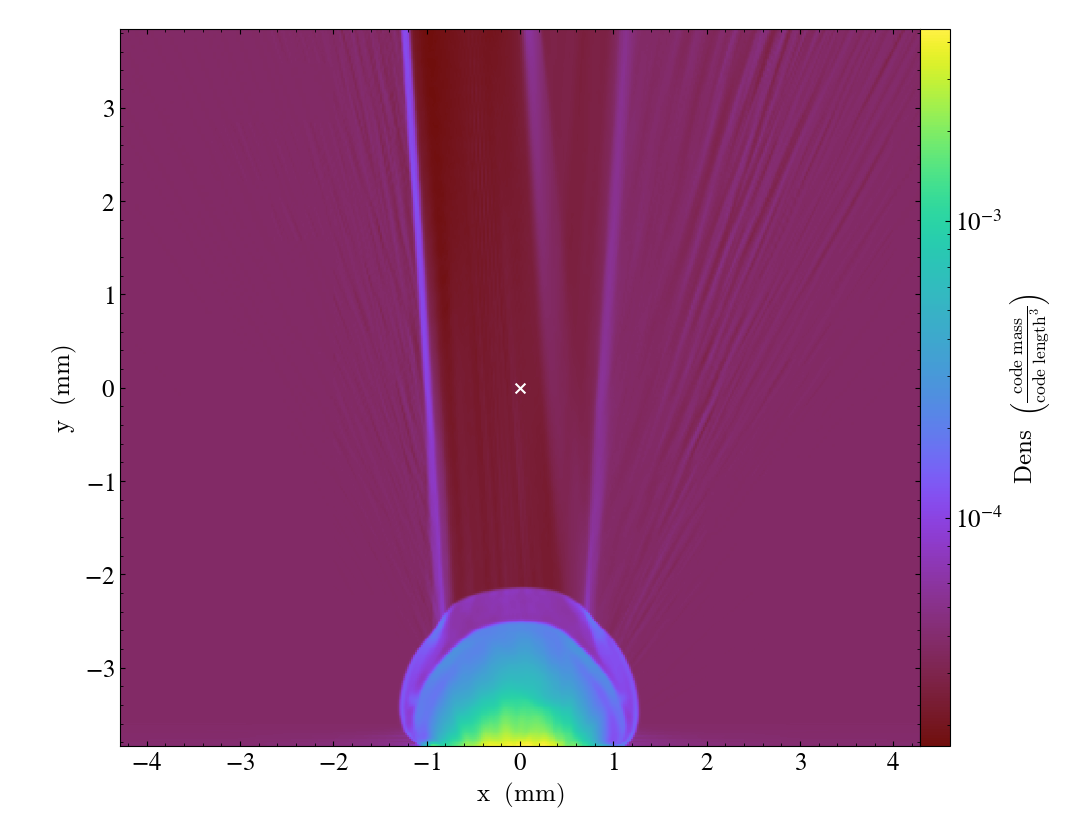

In [4]:
# Find some points in the channel to pull values from

# background_pt = [-0.4, 0.3, 0.0]
background_pt = [0, 0.4, 0.0]

rho_0 = pull_value_at_coord(background_pt,'dens',ds)

# looks good

In [5]:
# perform appropriate conversions to get the number density of ions and electrons

def make_ion_number_density(field, data):
    avogadro = 6.022e23
    ion_number_density = avogadro*data["flash","dens"]*data["flash","sumy"]
    return ion_number_density

def make_electron_number_density(field, data):
    avogadro = 6.022e23
    electron_number_density = avogadro*data["flash","dens"]*data["flash","ye"]
    return electron_number_density

def make_ele_per_ion(field, data):
    return data['flash','edens']/data['flash','idens']

ds.add_field(("flash", "idens"), function=make_ion_number_density, units="code_mass/code_length**3",sampling_type="cell") # technically the units are wrong here, should be massless
ds.add_field(("flash", "edens"), function=make_electron_number_density, units="code_mass/code_length**3",sampling_type="cell") # same here
ds.add_field(("flash", "ele_per_ion"), function=make_ele_per_ion,units="", sampling_type="cell")

yt : [INFO     ] 2024-08-23 15:59:46,346 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:46,346 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-08-23 15:59:46,348 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:46,348 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-08-23 15:59:46,349 Making a fixed resolution buffer of (('flash', 'ele_per_ion')) 800 by 800



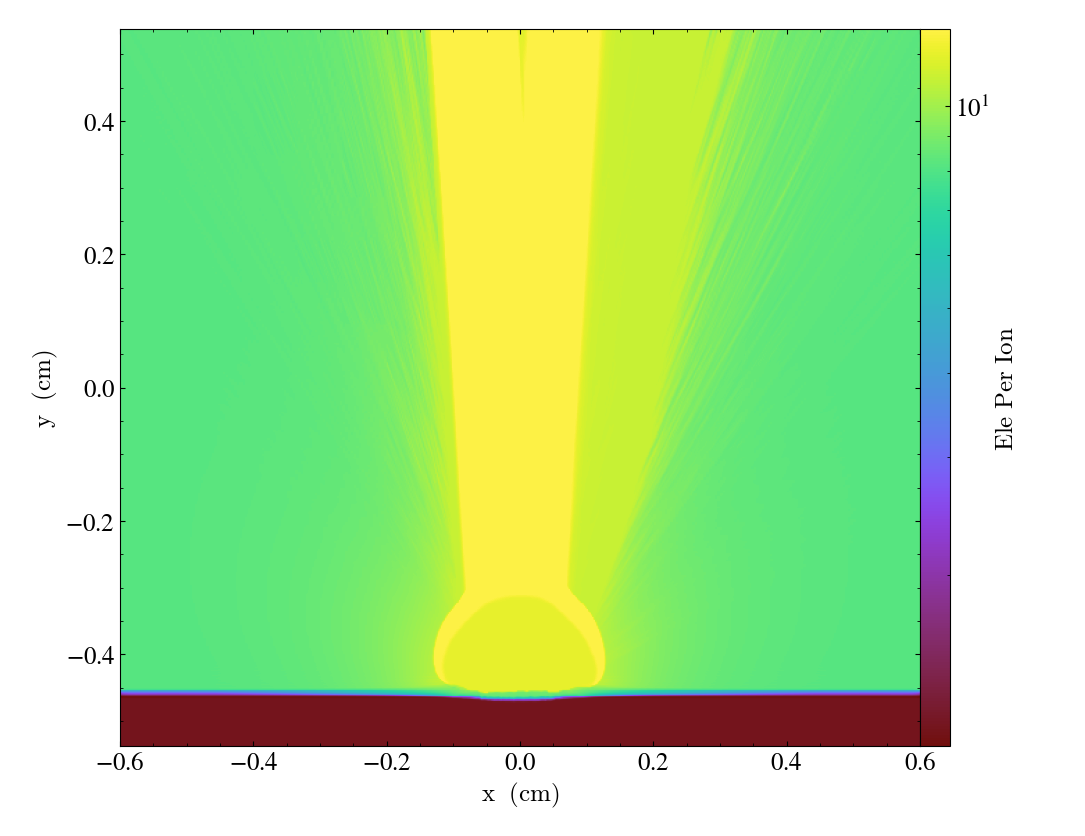

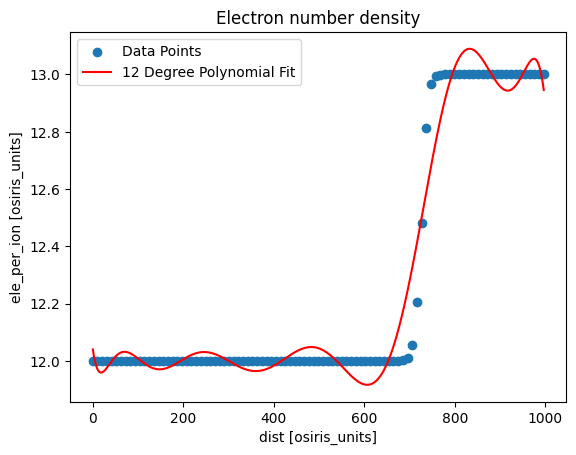

"if(x1 < 996.863641,  (195331.319834)*((x1 - 0.0)/996.863641)^(12) + (-1259585.307628)*((x1 - 0.0)/996.863641)^(11) + (3525180.271919)*((x1 - 0.0)/996.863641)^(10) + (-5622608.787026)*((x1 - 0.0)/996.863641)^(9) + (5642750.604574)*((x1 - 0.0)/996.863641)^(8) + (-3712494.757204)*((x1 - 0.0)/996.863641)^(7) + (1618476.537056)*((x1 - 0.0)/996.863641)^(6) + (-462009.002878)*((x1 - 0.0)/996.863641)^(5) + (83362.268626)*((x1 - 0.0)/996.863641)^(4) + (-8884.436779)*((x1 - 0.0)/996.863641)^(3) + (493.126799)*((x1 - 0.0)/996.863641)^(2) + (-10.931675)*((x1 - 0.0)/996.863641)^(1) + (12.039805)*((x1 - 0.0)/996.863641)^(0), 0.0)",

----------Desmos formatting to check your work----------

(195331.319834)*((x - 0.0)/996.863641)^12 + (-1259585.307628)*((x - 0.0)/996.863641)^11 + (3525180.271919)*((x - 0.0)/996.863641)^10 + (-5622608.787026)*((x - 0.0)/996.863641)^9 + (5642750.604574)*((x - 0.0)/996.863641)^8 + (-3712494.757204)*((x - 0.0)/996.863641)^7 + (1618476.537056)*((x - 0.0)/996.863641)^6 + (

In [6]:
slc = yt.SlicePlot(ds, "z", ("flash", 'ele_per_ion'))
slc.show()

from fitting_functions import fit_to_region
plt.title('Electron number density')
fit_to_region(start_pt=[0.0,0.01,0.0],end_pt=[0.0,0.2,0.0],field='ele_per_ion',degree=12,ds=ds, normalization=1, osiris=osiris,precision=6,left_value=None, right_value=0.0)

yt : [INFO     ] 2024-08-23 15:59:46,839 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:46,840 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:46,842 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:46,842 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:46,843 Making a fixed resolution buffer of (('flash', 'edens')) 800 by 800


edens at [0.  0.4 0. ] code_length: [7.19624975e+18] code_mass/code_length**3



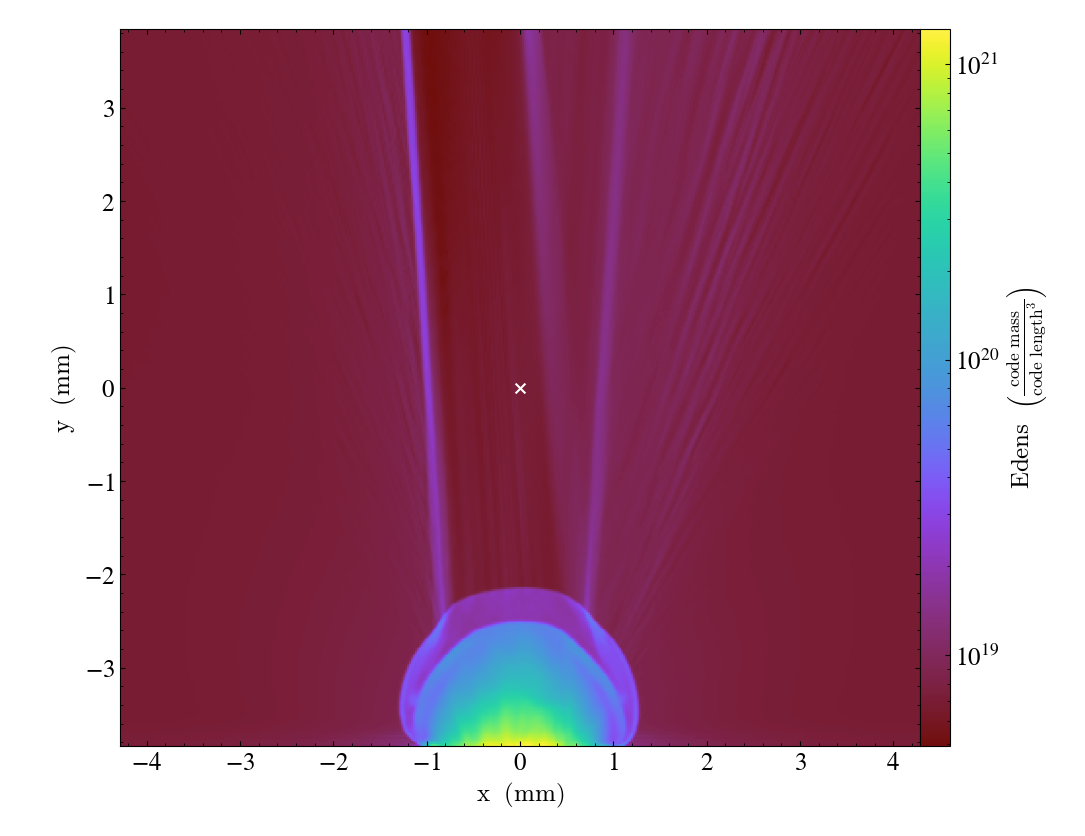

yt : [INFO     ] 2024-08-23 15:59:47,310 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:47,311 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:47,313 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:47,313 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:47,315 Making a fixed resolution buffer of (('flash', 'idens')) 800 by 800


idens at [0.  0.4 0. ] code_length: [5.53557785e+17] code_mass/code_length**3



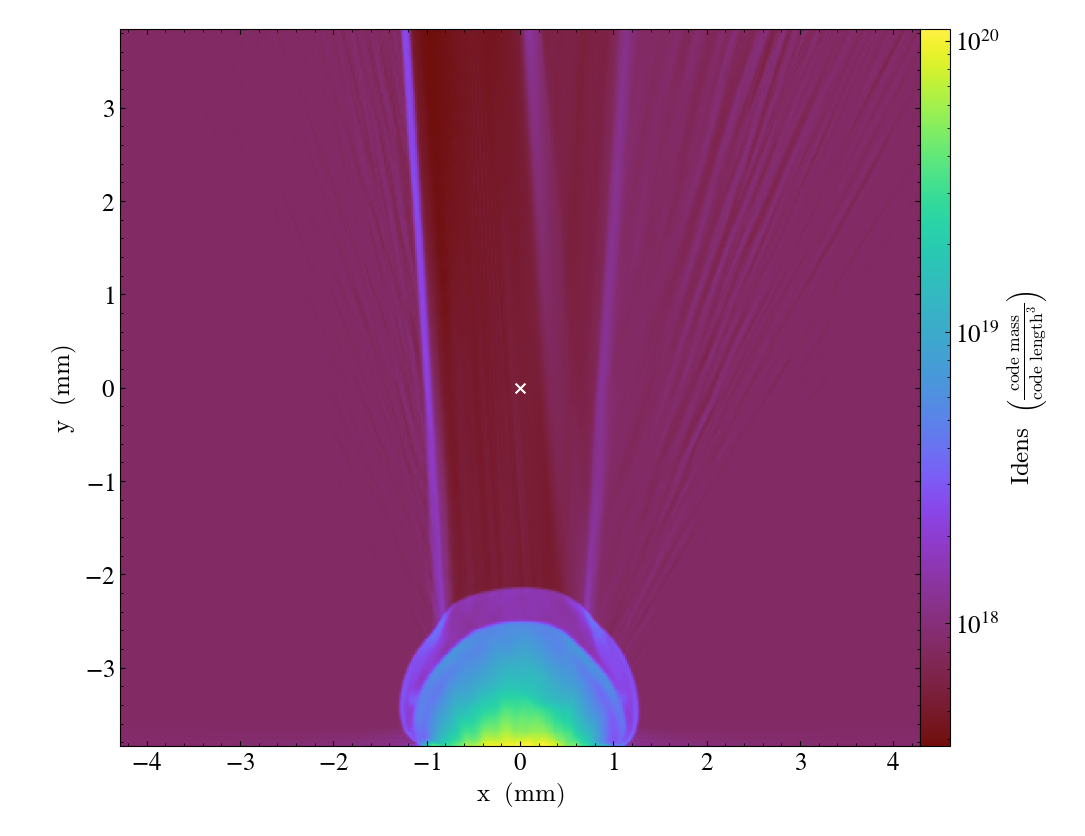

In [7]:
# background_pt = [-0.3, 0.12, 0.0]

ne_0 = pull_value_at_coord(background_pt,'edens',ds)
ni_0 = pull_value_at_coord(background_pt,'idens',ds)

Get alfven speed from the value of background B field in simulation

### $v_a = \frac{B}{\sqrt{4 \pi \rho}}$

yt : [INFO     ] 2024-08-23 15:59:47,820 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:47,821 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:47,822 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:47,823 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:47,824 Making a fixed resolution buffer of (('flash', 'magx')) 800 by 800


magx at [0.  0.4 0. ] code_length: [110226.77212444] code_magnetic



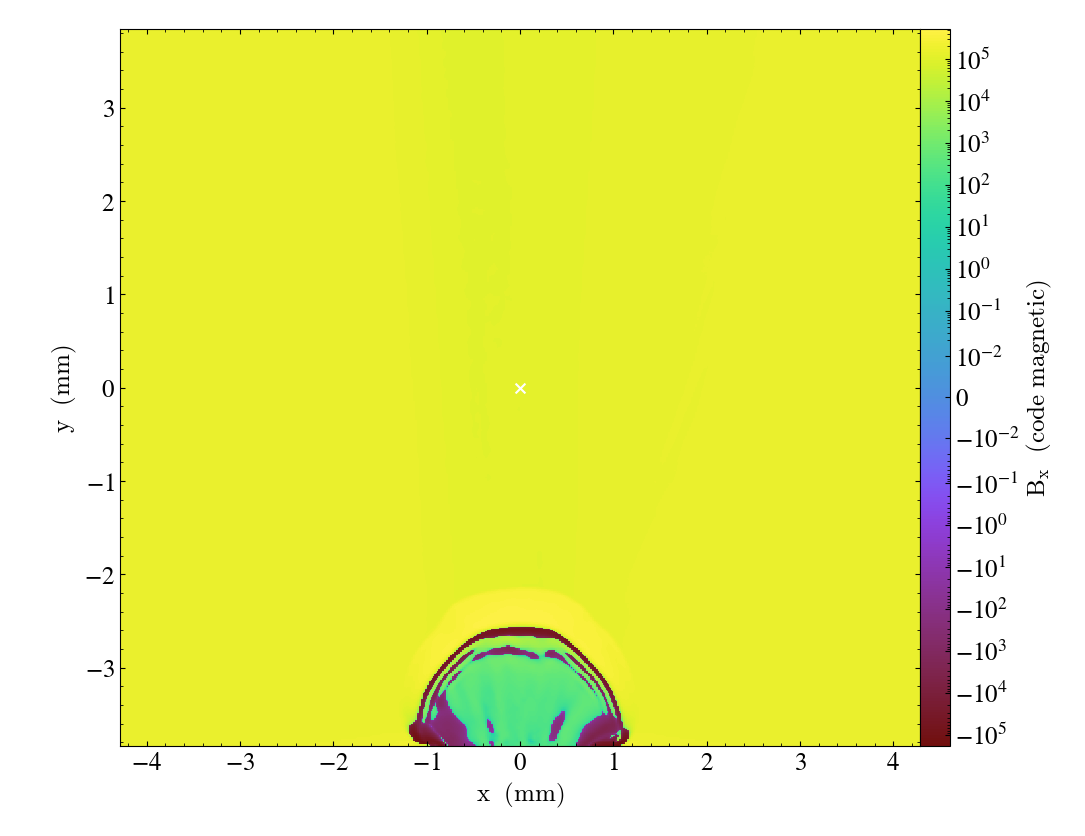

[6243815.75668848] code_length**(3/2)*code_magnetic/sqrt(code_mass)


In [8]:
Bx_0 = pull_value_at_coord(background_pt,'magx',ds)

v_alfven = Bx_0/np.sqrt(4*np.pi*rho_0)
print(v_alfven)

### Though it isn't visible in the above plot, there is actually a channel in the background magnetic field due to the incident laser

yt : [INFO     ] 2024-08-23 15:59:48,606 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:48,606 ylim = 0.062500 1.137500
yt : [INFO     ] 2024-08-23 15:59:48,608 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:48,609 ylim = 0.062500 1.137500
yt : [INFO     ] 2024-08-23 15:59:48,610 Making a fixed resolution buffer of (('flash', 'magx')) 800 by 800



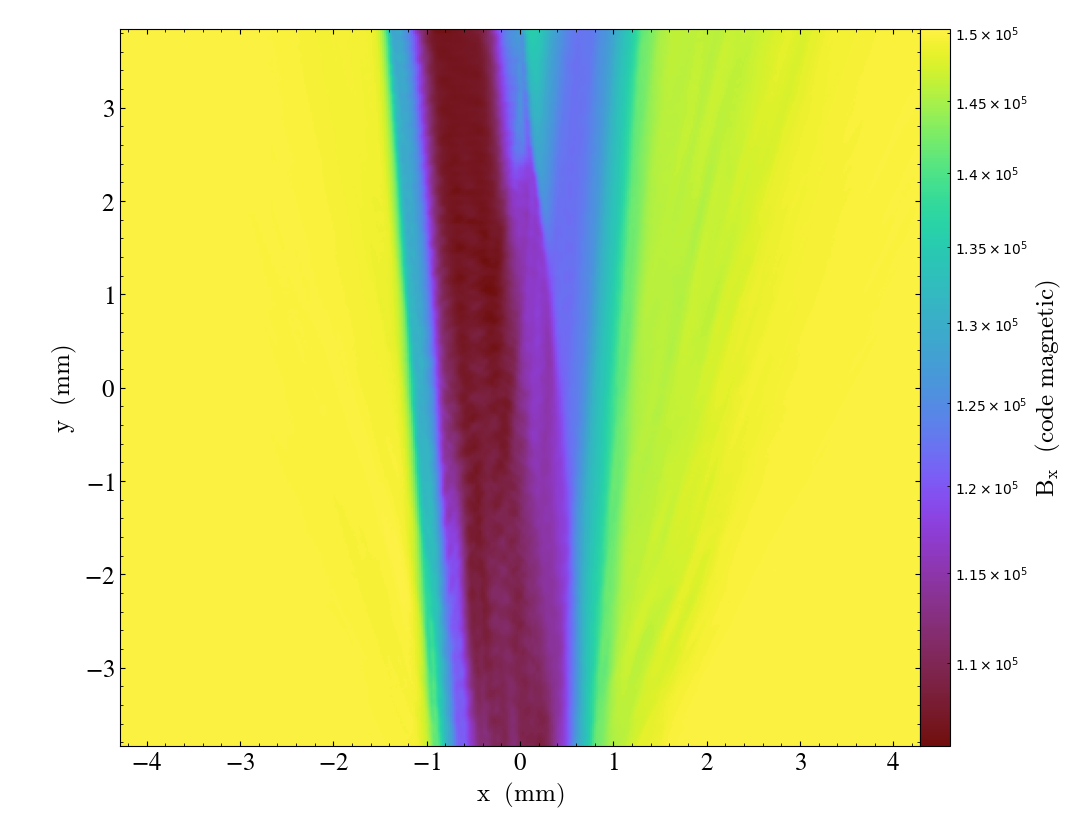

In [9]:
slc = yt.SlicePlot(ds, "z", "magx",center=[0,.6,0]).zoom(1.4)
slc.show()

Text(0, 0.5, 'Number Density [$cm^{-3}$]')

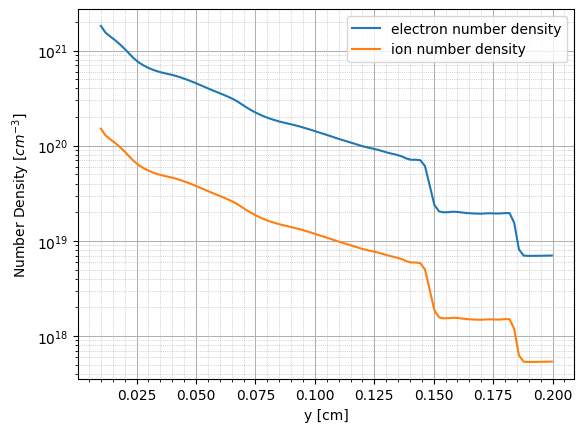

In [10]:
# Take a lineout of the number density to find where the target ends and where the piston begins
start_pt = (0.0,0.01,0.0)
end_pt = (0.0,0.2,0.0)
ray = ds.ray(start_pt, end_pt)

length_of_ray = np.sqrt((end_pt[0]-start_pt[0])**2 + (end_pt[1]-start_pt[1])**2 + (end_pt[2]-start_pt[2])**2)
dist_from_origin = np.sqrt(start_pt[0]**2 + start_pt[1]**2 + start_pt[2]**2)
ray_sort = np.argsort(ray["t"])
dist = np.array(ray[('t')]*length_of_ray+dist_from_origin)

y = np.array(ray[('flash','y')][ray_sort])
idens = np.array(ray[('flash','idens')][ray_sort])

edens = np.array(ray[('flash','edens')][ray_sort])
plt.semilogy(dist, edens, label='electron number density')
plt.semilogy(dist, idens, label='ion number density')
plt.legend()

from transform import pretty_plot
pretty_plot()


plt.xlabel('y [cm]')
plt.ylabel(r'Number Density [$cm^{-3}$]')
# based on this plot, it looks like the piston begins at y = 0.01

# print(edens[-200])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



mach number is between [3.69581088] and [17.17601614]


Text(0.5, 1.0, 'Velocity distribution of piston')

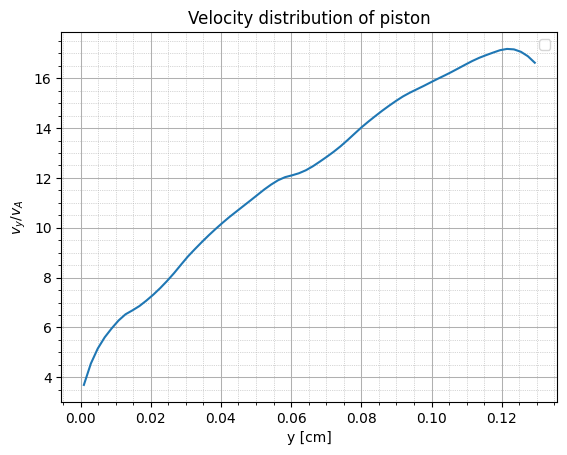

In [11]:
piston_ray = ds.ray((0, 0.01, 0), (0, .14, 0))
vely = np.array(piston_ray[('flash','vely')])
piston = np.array(piston_ray[('flash','y')])-0.01

plt.plot(piston, vely/v_alfven)
pretty_plot()
plt.legend()


mach_number_max = np.max(vely)/v_alfven
mach_number_min = np.min(vely)/v_alfven


print(f"\nmach number is between {mach_number_min.value} and {mach_number_max.value}")

plt.xlabel('y [cm]')
plt.ylabel(r'$v_y/v_A$')

plt.title('Velocity distribution of piston')
# plt.hlines(v_alfven, 0, 0.15, label='Alfven speed')

yt : [INFO     ] 2024-08-23 15:59:49,616 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:49,616 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:49,618 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:49,619 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:49,620 Making a fixed resolution buffer of (('flash', 'tion')) 800 by 800


tion at [0.  0.4 0. ] code_length: [1436956.15327951] code_temperature



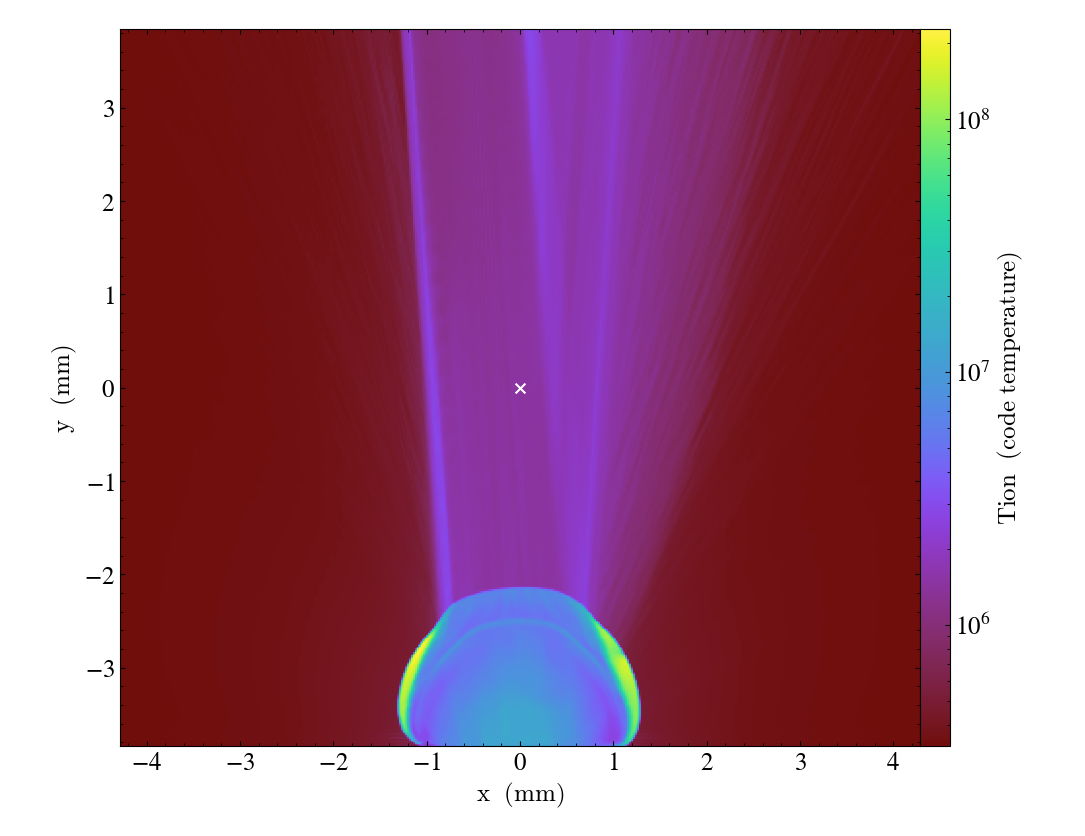

yt : [INFO     ] 2024-08-23 15:59:50,023 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:50,024 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:50,025 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:50,026 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:50,026 Making a fixed resolution buffer of (('flash', 'tele')) 800 by 800


tele at [0.  0.4 0. ] code_length: [12974580.64146048] code_temperature



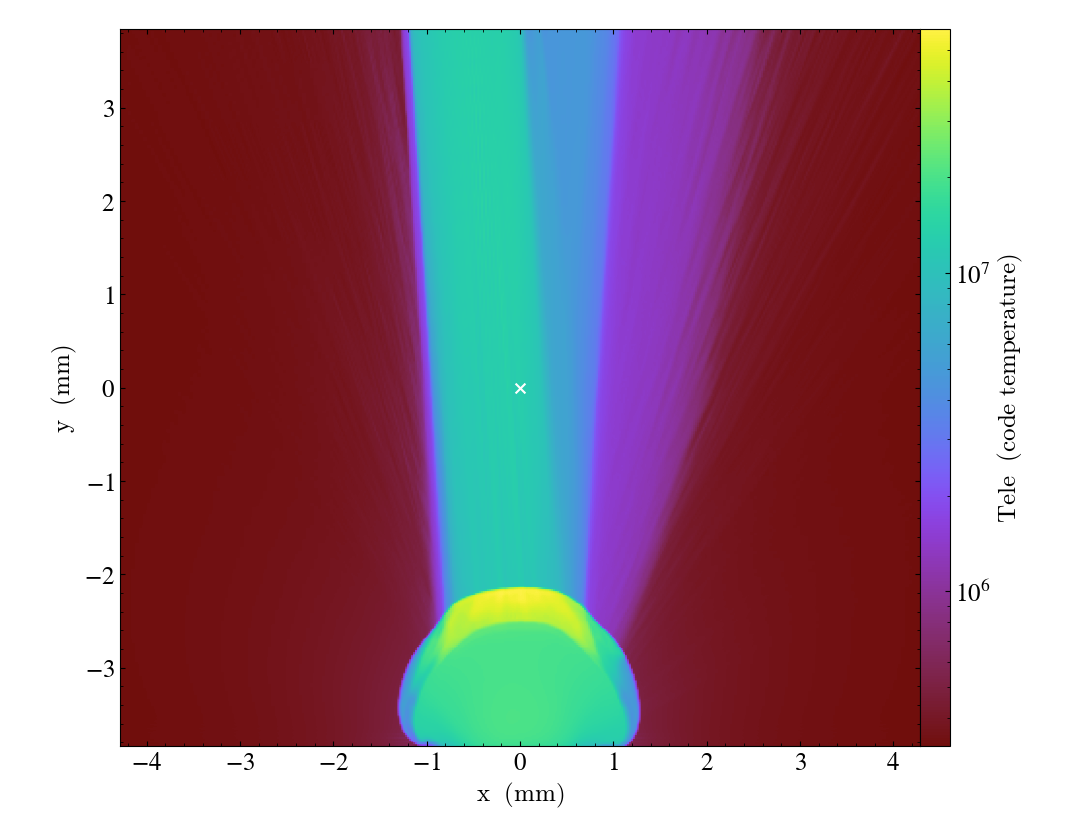

[-0.88924835] dimensionless


In [12]:
Ti_0 = pull_value_at_coord(background_pt,'tion',ds)

Te_0 = pull_value_at_coord(background_pt,'tele',ds)

print((Ti_0 - Te_0)/Te_0) # looks like the temperature difference is around 88%

## Now, start making (throwing) fits!

Some care needs to be taken with the fitting of the piston region and the compression after it. It looks like in the region around 750-900 [c/omega_pe], there is a compression of the background ions. Let's try to see if we can resolve this exactly

In [13]:
aluminum = pull_value_at_coord([0,0.20,0], "sumy",ds,plot = False)

magnesium = pull_value_at_coord([0,0.1,0], "sumy",ds, plot = False)

def make_magnesium_number_density(field, data):
    
    mg_percentage = (data["flash","sumy"]-aluminum)/(magnesium-aluminum)
    mg_number_density = mg_percentage*data["flash","idens"]
    return mg_number_density

def make_aluminum_number_density(field, data):
    mg_percentage = (data["flash","sumy"]-aluminum)/(magnesium-aluminum)
    al_number_density = (1-mg_percentage)*data["flash","idens"]
    return al_number_density

ds.add_field(("flash", "mgdens"), function=make_magnesium_number_density, units="code_mass/code_length**3",sampling_type="cell") # technically the units are wrong here, should be massless
ds.add_field(("flash", "aldens"), function=make_aluminum_number_density, units="code_mass/code_length**3",sampling_type="cell") # same here

yt : [INFO     ] 2024-08-23 15:59:50,485 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:50,486 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:50,488 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:50,489 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:50,490 Making a fixed resolution buffer of (('flash', 'sumy')) 800 by 800
yt : [INFO     ] 2024-08-23 15:59:50,625 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:50,626 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:50,627 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:50,628 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-23 15:59:50,629 Making a fixed resolution buffer of (('flash', 'sumy')) 800 by 800


sumy at [0.  0.2 0. ] code_length: [0.03706449] dimensionless
sumy at [0.  0.1 0. ] code_length: [0.04114372] dimensionless


In [14]:
piston_start = [0,0.01,0];piston_end = [0,0.149,0]

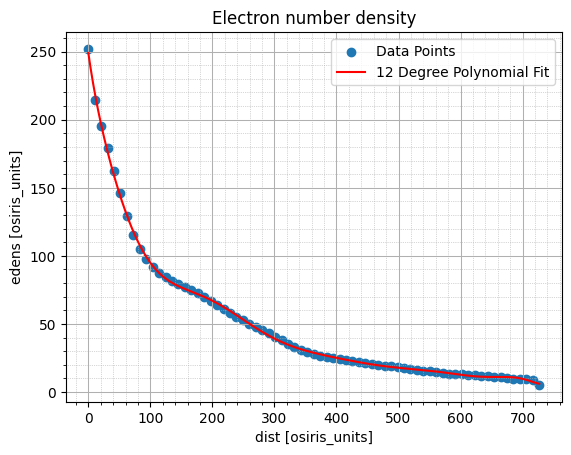

"if(x1 < 726.84049,  (6370972.420242)*((x1 - 0.0)/726.84049)^(12) + (-39742100.136893)*((x1 - 0.0)/726.84049)^(11) + (108729501.547577)*((x1 - 0.0)/726.84049)^(10) + (-171251229.395475)*((x1 - 0.0)/726.84049)^(9) + (171269557.234635)*((x1 - 0.0)/726.84049)^(8) + (-113087847.486855)*((x1 - 0.0)/726.84049)^(7) + (49644422.293427)*((x1 - 0.0)/726.84049)^(6) + (-14243639.775576)*((x1 - 0.0)/726.84049)^(5) + (2575942.873519)*((x1 - 0.0)/726.84049)^(4) + (-286909.780671)*((x1 - 0.0)/726.84049)^(3) + (23423.819117)*((x1 - 0.0)/726.84049)^(2) + (-2336.483204)*((x1 - 0.0)/726.84049)^(1) + (248.962260)*((x1 - 0.0)/726.84049)^(0), 0.0)",

----------Desmos formatting to check your work----------

(6370972.420242)*((x - 0.0)/726.84049)^12 + (-39742100.136893)*((x - 0.0)/726.84049)^11 + (108729501.547577)*((x - 0.0)/726.84049)^10 + (-171251229.395475)*((x - 0.0)/726.84049)^9 + (171269557.234635)*((x - 0.0)/726.84049)^8 + (-113087847.486855)*((x - 0.0)/726.84049)^7 + (49644422.293427)*((x - 0.0)/726.

In [15]:
pretty_plot()
plt.title('Electron number density')
fit_to_region(start_pt=piston_start,end_pt=piston_end,field='edens',degree=12,ds=ds, normalization=ne_0, osiris=osiris,precision=6,left_value=None, right_value=0.0)

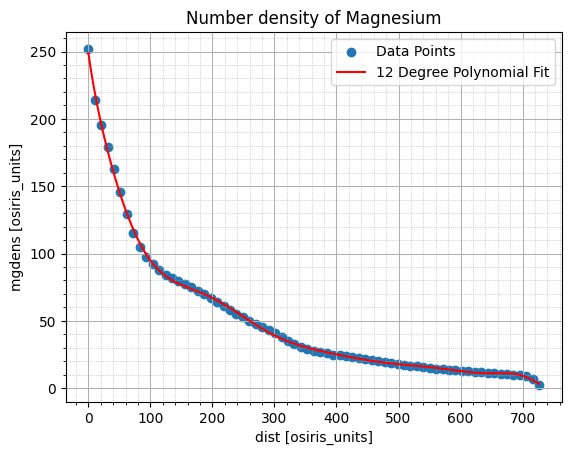

"if(x1 < 726.84049,  (6443194.521899)*((x1 - 0.0)/726.84049)^(12) + (-40206340.334071)*((x1 - 0.0)/726.84049)^(11) + (110015047.75606)*((x1 - 0.0)/726.84049)^(10) + (-173271689.581762)*((x1 - 0.0)/726.84049)^(9) + (173264383.907158)*((x1 - 0.0)/726.84049)^(8) + (-114379341.642074)*((x1 - 0.0)/726.84049)^(7) + (50199370.201206)*((x1 - 0.0)/726.84049)^(6) + (-14400189.712961)*((x1 - 0.0)/726.84049)^(5) + (2603953.918671)*((x1 - 0.0)/726.84049)^(4) + (-289884.606485)*((x1 - 0.0)/726.84049)^(3) + (23590.110458)*((x1 - 0.0)/726.84049)^(2) + (-2340.395887)*((x1 - 0.0)/726.84049)^(1) + (248.993423)*((x1 - 0.0)/726.84049)^(0), 0.0)",

----------Desmos formatting to check your work----------

(6443194.521899)*((x - 0.0)/726.84049)^12 + (-40206340.334071)*((x - 0.0)/726.84049)^11 + (110015047.75606)*((x - 0.0)/726.84049)^10 + (-173271689.581762)*((x - 0.0)/726.84049)^9 + (173264383.907158)*((x - 0.0)/726.84049)^8 + (-114379341.642074)*((x - 0.0)/726.84049)^7 + (50199370.201206)*((x - 0.0)/726.84

In [16]:
pretty_plot()
plt.title('Number density of Magnesium')
fit_to_region(start_pt=piston_start,end_pt=piston_end,field='mgdens',degree=12,ds=ds, normalization=ne_0/12, osiris=osiris,precision=6,left_value=None, right_value=0.0)

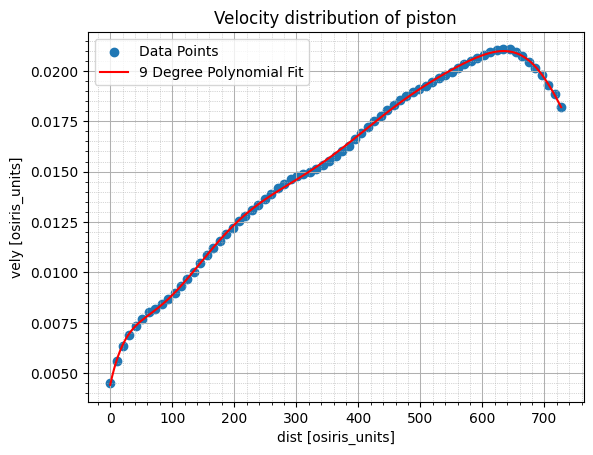

"(17.448884)*((x1 - 0.0)/726.84049)^(9) +(-84.489885)*((x1 - 0.0)/726.84049)^(8) +(172.203460)*((x1 - 0.0)/726.84049)^(7) +(-191.802441)*((x1 - 0.0)/726.84049)^(6) +(126.621815)*((x1 - 0.0)/726.84049)^(5) +(-50.193628)*((x1 - 0.0)/726.84049)^(4) +(11.543659)*((x1 - 0.0)/726.84049)^(3) +(-1.421126)*((x1 - 0.0)/726.84049)^(2) +(0.103030)*((x1 - 0.0)/726.84049)^(1) +(0.004429)*((x1 - 0.0)/726.84049)^(0)",

----------Desmos formatting to check your work----------

(17.448884)*((x - 0.0)/726.84049)^9 + (-84.489885)*((x - 0.0)/726.84049)^8 + (172.203460)*((x - 0.0)/726.84049)^7 + (-191.802441)*((x - 0.0)/726.84049)^6 + (126.621815)*((x - 0.0)/726.84049)^5 + (-50.193628)*((x - 0.0)/726.84049)^4 + (11.543659)*((x - 0.0)/726.84049)^3 + (-1.421126)*((x - 0.0)/726.84049)^2 + (0.103030)*((x - 0.0)/726.84049)^1 + (0.004429)*((x - 0.0)/726.84049)^0


In [17]:
pretty_plot()
plt.title('Velocity distribution of piston')
fit_to_region(start_pt=piston_start,end_pt=piston_end,field='vely',degree=9,ds=ds, normalization=v_alfven/ osiris['alfven_speed'], osiris=osiris,precision=6,left_value=None, right_value=None)

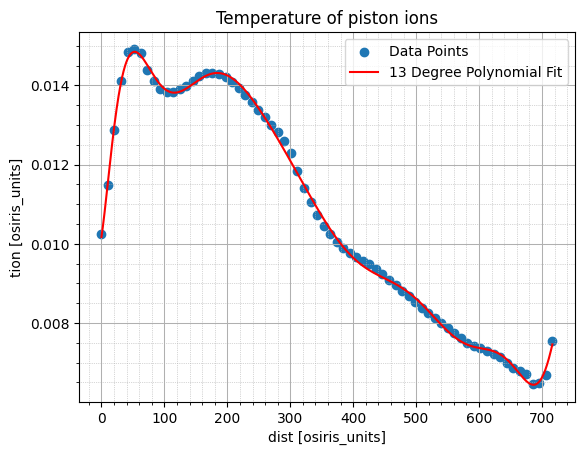

"(-3769.206567)*((x1 - 0.0)/716.454985)^(13) +(25272.925185)*((x1 - 0.0)/716.454985)^(12) +(-75212.318865)*((x1 - 0.0)/716.454985)^(11) +(130917.006683)*((x1 - 0.0)/716.454985)^(10) +(-147822.419544)*((x1 - 0.0)/716.454985)^(9) +(113451.741551)*((x1 - 0.0)/716.454985)^(8) +(-60239.249495)*((x1 - 0.0)/716.454985)^(7) +(22050.560185)*((x1 - 0.0)/716.454985)^(6) +(-5422.764044)*((x1 - 0.0)/716.454985)^(5) +(844.33864)*((x1 - 0.0)/716.454985)^(4) +(-72.921543)*((x1 - 0.0)/716.454985)^(3) +(2.227217)*((x1 - 0.0)/716.454985)^(2) +(0.077887)*((x1 - 0.0)/716.454985)^(1) +(0.01017)*((x1 - 0.0)/716.454985)^(0)",

----------Desmos formatting to check your work----------

(-3769.206567)*((x - 0.0)/716.454985)^13 + (25272.925185)*((x - 0.0)/716.454985)^12 + (-75212.318865)*((x - 0.0)/716.454985)^11 + (130917.006683)*((x - 0.0)/716.454985)^10 + (-147822.419544)*((x - 0.0)/716.454985)^9 + (113451.741551)*((x - 0.0)/716.454985)^8 + (-60239.249495)*((x - 0.0)/716.454985)^7 + (22050.560185)*((x - 0.0)/7

In [18]:
pretty_plot()
plt.title('Temperature of piston ions')
fit_to_region(start_pt=piston_start,end_pt=[0,0.148,0],field='tion',degree=13,ds=ds, normalization=Ti_0.value/osiris['Tpiston'], osiris=osiris,precision=6,left_value=None, right_value=None)

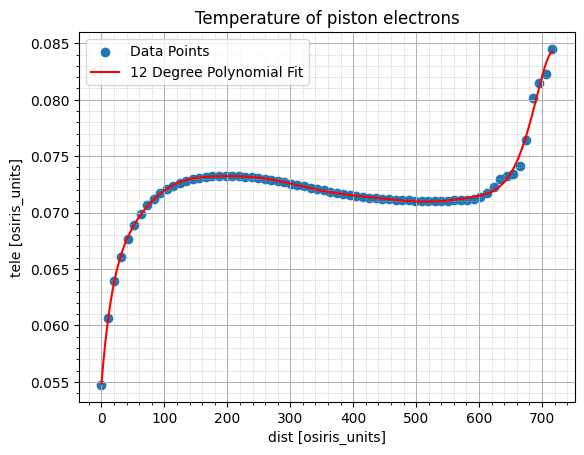

"(-1559.349446)*((x1 - 0.0)/716.454985)^(12) +(9263.943155)*((x1 - 0.0)/716.454985)^(11) +(-24246.00861)*((x1 - 0.0)/716.454985)^(10) +(36796.996168)*((x1 - 0.0)/716.454985)^(9) +(-35870.813060)*((x1 - 0.0)/716.454985)^(8) +(23513.523802)*((x1 - 0.0)/716.454985)^(7) +(-10552.252421)*((x1 - 0.0)/716.454985)^(6) +(3242.737741)*((x1 - 0.0)/716.454985)^(5) +(-673.410725)*((x1 - 0.0)/716.454985)^(4) +(92.426224)*((x1 - 0.0)/716.454985)^(3) +(-8.255462)*((x1 - 0.0)/716.454985)^(2) +(0.492050)*((x1 - 0.0)/716.454985)^(1) +(0.054839)*((x1 - 0.0)/716.454985)^(0)",

----------Desmos formatting to check your work----------

(-1559.349446)*((x - 0.0)/716.454985)^12 + (9263.943155)*((x - 0.0)/716.454985)^11 + (-24246.00861)*((x - 0.0)/716.454985)^10 + (36796.996168)*((x - 0.0)/716.454985)^9 + (-35870.813060)*((x - 0.0)/716.454985)^8 + (23513.523802)*((x - 0.0)/716.454985)^7 + (-10552.252421)*((x - 0.0)/716.454985)^6 + (3242.737741)*((x - 0.0)/716.454985)^5 + (-673.410725)*((x - 0.0)/716.454985)^4 +

In [19]:
pretty_plot()
plt.title('Temperature of piston electrons')
fit_to_region(start_pt=piston_start,end_pt=[0,0.148,0],field='tele',degree=12,ds=ds, normalization=Te_0.value/osiris['Te'], osiris=osiris,precision=6,left_value=None, right_value=None)

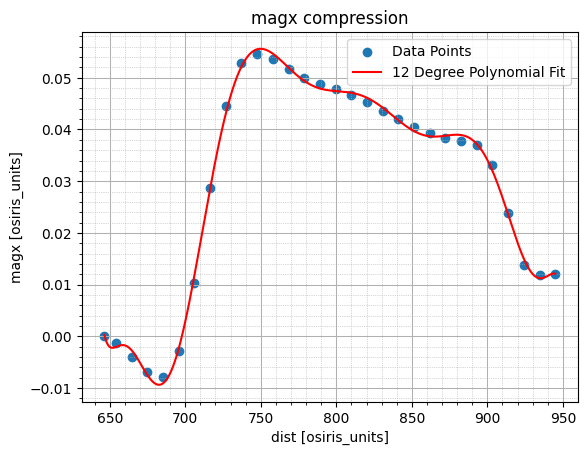

"if(x1 < 646.432523, 0, if(x1 < 944.936112,  (3529.714887)*((x1 - 646.432523)/298.503588)^(12) + (-26785.969127)*((x1 - 646.432523)/298.503588)^(11) + (86781.804418)*((x1 - 646.432523)/298.503588)^(10) + (-158521.37377)*((x1 - 646.432523)/298.503588)^(9) + (180749.225765)*((x1 - 646.432523)/298.503588)^(8) + (-134021.489965)*((x1 - 646.432523)/298.503588)^(7) + (65059.204101)*((x1 - 646.432523)/298.503588)^(6) + (-20223.400077)*((x1 - 646.432523)/298.503588)^(5) + (3802.742049)*((x1 - 646.432523)/298.503588)^(4) + (-388.670963)*((x1 - 646.432523)/298.503588)^(3) + (18.594250)*((x1 - 646.432523)/298.503588)^(2) + (-0.369772)*((x1 - 646.432523)/298.503588)^(1) + (0.000316)*((x1 - 646.432523)/298.503588)^(0), 0.012))",

----------Desmos formatting to check your work----------

(3529.714887)*((x - 646.432523)/298.503588)^12 + (-26785.969127)*((x - 646.432523)/298.503588)^11 + (86781.804418)*((x - 646.432523)/298.503588)^10 + (-158521.37377)*((x - 646.432523)/298.503588)^9 + (180749.225765)

In [20]:
pretty_plot()
plt.title('magx compression')
fit_to_region(start_pt=[0.0,0.133,0.0],end_pt=[0.0,0.19,0.0],field='magx',degree=12,ds=ds, normalization=Bx_0.value/ osiris['B'], osiris=osiris,precision=6,left_value=0, right_value=osiris['B'])

### We need to create the electric field and put those into OSIRIS in order to maintain ideal MHD

In [21]:
def make_Ex(field, data):
    Ex = data['flash','velz']*data["flash","magy"]-data["flash","vely"]*data["flash","magz"]
    return Ex

def make_Ey(field, data):
    Ey = data['flash','velx']*data["flash","magz"]-data["flash","velz"]*data["flash","magx"]
    return Ey

def make_Ez(field, data):
    Ez = data['flash','vely']*data["flash","magx"]-data["flash","velx"]*data["flash","magy"]
    return Ez

ds.add_field(("flash", "Ex"), function=make_Ex, units="code_magnetic*code_length/code_time",sampling_type="cell") #technically the units are wrong here
ds.add_field(("flash", "Ey"), function=make_Ey, units="code_magnetic*code_length/code_time",sampling_type="cell")
ds.add_field(("flash", "Ez"), function=make_Ez, units="code_magnetic*code_length/code_time",sampling_type="cell")

yt : [INFO     ] 2024-08-23 15:59:51,999 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:52,000 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-08-23 15:59:52,002 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-23 15:59:52,002 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-08-23 15:59:52,003 Making a fixed resolution buffer of (('flash', 'Ez')) 800 by 800



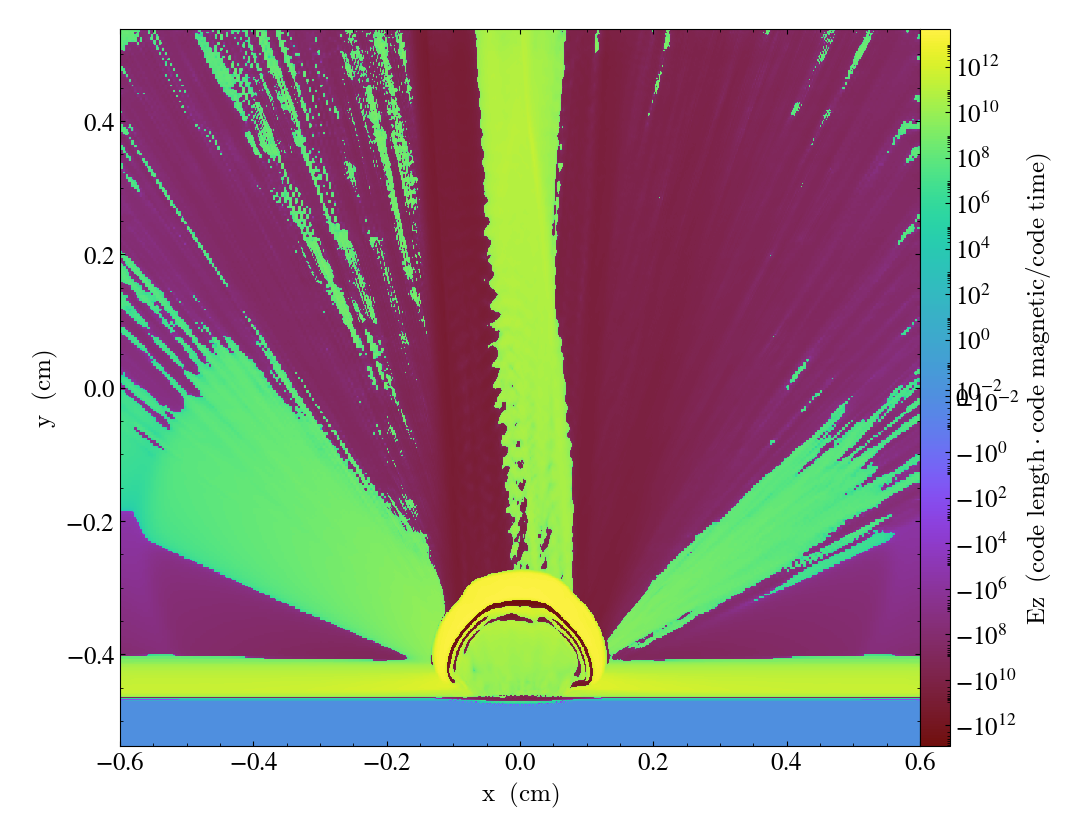

In [22]:
yt.SlicePlot(ds, 'z', ('flash', 'Ez')).show()

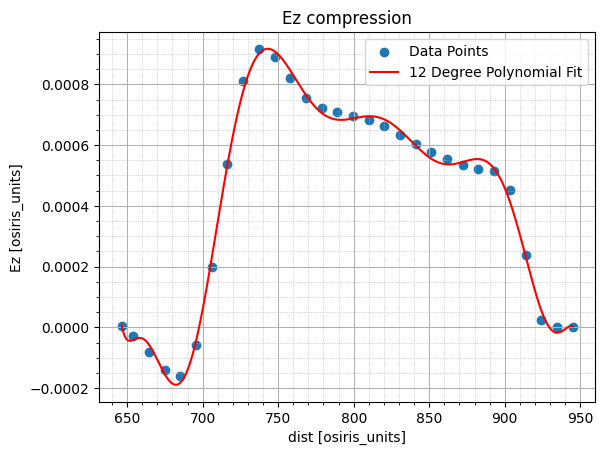

"if(x1 < 646.432523, 0, if(x1 < 944.936112,  (84.516845)*((x1 - 646.432523)/298.503588)^(12) + (-628.629510)*((x1 - 646.432523)/298.503588)^(11) + (2002.791657)*((x1 - 646.432523)/298.503588)^(10) + (-3603.519246)*((x1 - 646.432523)/298.503588)^(9) + (4049.286421)*((x1 - 646.432523)/298.503588)^(8) + (-2958.110245)*((x1 - 646.432523)/298.503588)^(7) + (1413.481378)*((x1 - 646.432523)/298.503588)^(6) + (-431.937437)*((x1 - 646.432523)/298.503588)^(5) + (79.759029)*((x1 - 646.432523)/298.503588)^(4) + (-8.008078)*((x1 - 646.432523)/298.503588)^(3) + (0.376584)*((x1 - 646.432523)/298.503588)^(2) + (-0.007402)*((x1 - 646.432523)/298.503588)^(1) + (0.000006)*((x1 - 646.432523)/298.503588)^(0), 0.0))",

----------Desmos formatting to check your work----------

(84.516845)*((x - 646.432523)/298.503588)^12 + (-628.629510)*((x - 646.432523)/298.503588)^11 + (2002.791657)*((x - 646.432523)/298.503588)^10 + (-3603.519246)*((x - 646.432523)/298.503588)^9 + (4049.286421)*((x - 646.432523)/298.50358

In [23]:
pretty_plot()
plt.title('Ez compression')
fit_to_region(start_pt=[0.0,0.133,0.0],end_pt=[0.0,0.19,0.0],field='Ez',degree=12,ds=ds, normalization=Bx_0.value/ osiris['B']*v_alfven/osiris['alfven_speed'], osiris=osiris,precision=6,left_value=0, right_value=0.0)

### Get the density compression of the aluminum plasma

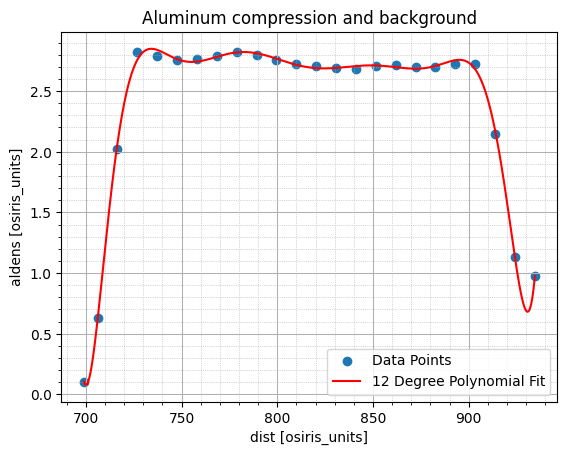

"if(x1 < 698.988, 0.0, if(x1 < 934.5506,  (153756.6928)*((x1 - 698.988)/235.5626)^(12) + (-940360.0352)*((x1 - 698.988)/235.5626)^(11) + (2599955.0582)*((x1 - 698.988)/235.5626)^(10) + (-4285529.6428)*((x1 - 698.988)/235.5626)^(9) + (4661673.4889)*((x1 - 698.988)/235.5626)^(8) + (-3489458.7109)*((x1 - 698.988)/235.5626)^(7) + (1815320.9510)*((x1 - 698.988)/235.5626)^(6) + (-647104.6089)*((x1 - 698.988)/235.5626)^(5) + (151794.3295)*((x1 - 698.988)/235.5626)^(4) + (-21539.3082)*((x1 - 698.988)/235.5626)^(3) + (1505.3188)*((x1 - 698.988)/235.5626)^(2) + (-12.6658)*((x1 - 698.988)/235.5626)^(1) + (0.1078)*((x1 - 698.988)/235.5626)^(0), 1.0))",

----------Desmos formatting to check your work----------

(153756.6928)*((x - 698.988)/235.5626)^12 + (-940360.0352)*((x - 698.988)/235.5626)^11 + (2599955.0582)*((x - 698.988)/235.5626)^10 + (-4285529.6428)*((x - 698.988)/235.5626)^9 + (4661673.4889)*((x - 698.988)/235.5626)^8 + (-3489458.7109)*((x - 698.988)/235.5626)^7 + (1815320.9510)*((x - 698

In [24]:
pretty_plot()
plt.title('Aluminum compression and background')
fit_to_region(start_pt=[0.0,0.143,0.0],end_pt=[0.0,0.188,0.0],field='aldens',degree=12,ds=ds, normalization=ne_0/13, osiris=osiris,precision=4,left_value=0.0, right_value=1.0)

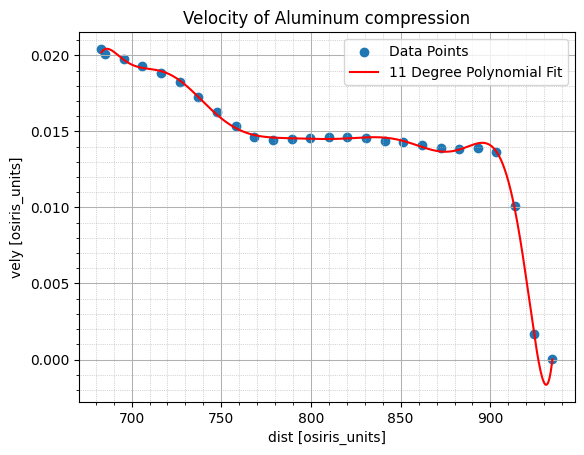

"if(x1 < 683.221366, 0.02, if(x1 < 934.550606,  (867.681766)*((x1 - 683.221366)/251.32924)^(11) + (-4520.608618)*((x1 - 683.221366)/251.32924)^(10) + (10179.697114)*((x1 - 683.221366)/251.32924)^(9) + (-12975.478631)*((x1 - 683.221366)/251.32924)^(8) + (10290.935821)*((x1 - 683.221366)/251.32924)^(7) + (-5251.591462)*((x1 - 683.221366)/251.32924)^(6) + (1720.142333)*((x1 - 683.221366)/251.32924)^(5) + (-349.229600)*((x1 - 683.221366)/251.32924)^(4) + (40.79451)*((x1 - 683.221366)/251.32924)^(3) + (-2.406016)*((x1 - 683.221366)/251.32924)^(2) + (0.04259)*((x1 - 683.221366)/251.32924)^(1) + (0.020203)*((x1 - 683.221366)/251.32924)^(0), 0.0))",

----------Desmos formatting to check your work----------

(867.681766)*((x - 683.221366)/251.32924)^11 + (-4520.608618)*((x - 683.221366)/251.32924)^10 + (10179.697114)*((x - 683.221366)/251.32924)^9 + (-12975.478631)*((x - 683.221366)/251.32924)^8 + (10290.935821)*((x - 683.221366)/251.32924)^7 + (-5251.591462)*((x - 683.221366)/251.32924)^6 + (1

In [25]:
pretty_plot()
plt.title('Velocity of Aluminum compression')
fit_to_region(start_pt=[0.0,0.14,0.0],end_pt=[0.0,0.188,0.0],field='vely',degree=11,ds=ds, normalization=v_alfven/osiris['alfven_speed'], osiris=osiris,precision=6,left_value=0.02, right_value=0.0)

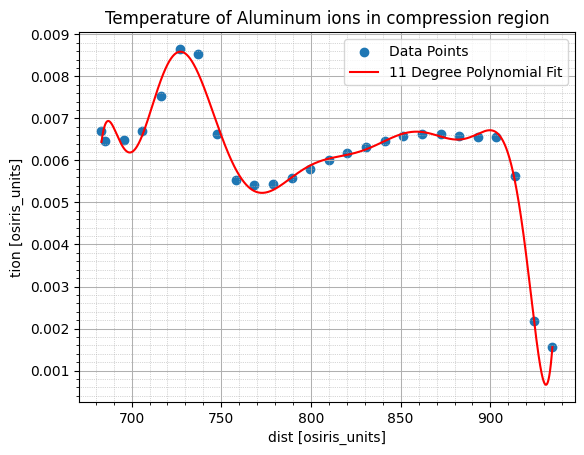

"if(x1 < 934.550606,  (924.28228)*((x1 - 683.221366)/251.32924)^(11) + (-5080.959095)*((x1 - 683.221366)/251.32924)^(10) + (12108.706230)*((x1 - 683.221366)/251.32924)^(9) + (-16375.86965)*((x1 - 683.221366)/251.32924)^(8) + (13805.38767)*((x1 - 683.221366)/251.32924)^(7) + (-7493.975845)*((x1 - 683.221366)/251.32924)^(6) + (2607.83234)*((x1 - 683.221366)/251.32924)^(5) + (-559.308801)*((x1 - 683.221366)/251.32924)^(4) + (67.721410)*((x1 - 683.221366)/251.32924)^(3) + (-3.89974)*((x1 - 683.221366)/251.32924)^(2) + (0.078320)*((x1 - 683.221366)/251.32924)^(1) + (0.006439)*((x1 - 683.221366)/251.32924)^(0), 0.0016)",

----------Desmos formatting to check your work----------

(924.28228)*((x - 683.221366)/251.32924)^11 + (-5080.959095)*((x - 683.221366)/251.32924)^10 + (12108.706230)*((x - 683.221366)/251.32924)^9 + (-16375.86965)*((x - 683.221366)/251.32924)^8 + (13805.38767)*((x - 683.221366)/251.32924)^7 + (-7493.975845)*((x - 683.221366)/251.32924)^6 + (2607.83234)*((x - 683.221366)/2

In [26]:
pretty_plot()
plt.title('Temperature of Aluminum ions in compression region')
fit_to_region(start_pt=[0.0,0.14,0.0],end_pt=[0.0,0.188,0.0],field='tion', degree=11,ds=ds, normalization= Ti_0/osiris['Tpiston'], osiris=osiris, precision=6,left_value=None, right_value=round(osiris['Tpiston'],4))

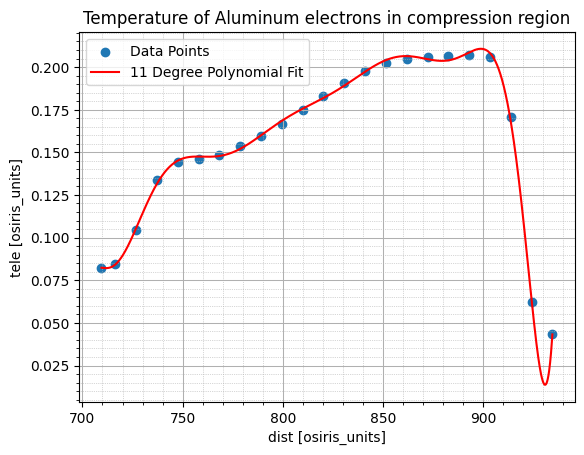

"if(x1 < 934.55060604,  (10384.9844337)*((x1 - 709.49911105)/225.05149499)^(11) + (-53000.8821021)*((x1 - 709.49911105)/225.05149499)^(10) + (116181.517507)*((x1 - 709.49911105)/225.05149499)^(9) + (-142880.13694829)*((x1 - 709.49911105)/225.05149499)^(8) + (107899.31593896)*((x1 - 709.49911105)/225.05149499)^(7) + (-51341.37226508)*((x1 - 709.49911105)/225.05149499)^(6) + (15105.80210014)*((x1 - 709.49911105)/225.05149499)^(5) + (-2543.73135108)*((x1 - 709.49911105)/225.05149499)^(4) + (195.51264147)*((x1 - 709.49911105)/225.05149499)^(3) + (-1.01957422)*((x1 - 709.49911105)/225.05149499)^(2) + (-0.02948288)*((x1 - 709.49911105)/225.05149499)^(1) + (0.08233878)*((x1 - 709.49911105)/225.05149499)^(0), 0.0468)",

----------Desmos formatting to check your work----------

(10384.9844337)*((x - 709.49911105)/225.05149499)^11 + (-53000.8821021)*((x - 709.49911105)/225.05149499)^10 + (116181.517507)*((x - 709.49911105)/225.05149499)^9 + (-142880.13694829)*((x - 709.49911105)/225.05149499)^8 

In [27]:
pretty_plot()
plt.title('Temperature of Aluminum electrons in compression region')
fit_to_region(start_pt=[0.0,0.145,0.0],end_pt=[0.0,0.189,0.0],field='tele', degree=11,ds=ds, normalization= Te_0.value/osiris['Te'], osiris=osiris, precision=8,left_value=None, right_value=round(osiris['Te'],4))